In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy import interpolate
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp2d, griddata
from scipy import optimize
from scipy import interpolate
from scipy.optimize import curve_fit


In [3]:
data = pd.read_csv('data_fs.dat', delim_whitespace=True, decimal=",")
data

,id,x,y,z,fwhm_x,fwhm_y,e,tilt,co_max,cx_max,xpd,sub_spill,main_spill
0,21,-0.316965,0.326756,50,0.398546,0.365183,1.091361,131.516741,53.84,"13,1",40.74,0.001675,0.005413
1,42,-0.318192,0.272044,50,0.364137,0.398634,1.094738,36.860917,53.86,"12,79",41.07,0.001237,0.004431
2,63,-0.319138,0.217441,50,0.364608,0.396464,1.087371,31.285228,53.88,"12,11",41.77,0.000910,0.004168
3,83,-0.320197,0.163140,45,0.361428,0.384678,1.064326,22.716133,54.07,"12,21",41.85,0.000715,0.003629
4,103,-0.321053,0.108822,40,0.358714,0.376443,1.049424,17.159739,54.20,"11,6",42.60,0.000600,0.003919
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,3464,0.329983,-0.108774,45,0.351460,0.385294,1.096266,12.457245,54.17,"12,91",41.25,0.000344,0.010594
165,3486,0.330462,-0.163029,50,0.351985,0.395278,1.122996,17.597785,54.04,"13,01",41.03,0.000430,0.010768
166,3507,0.331717,-0.217468,50,0.351115,0.398046,1.133661,22.414060,54.02,"12,87",41.15,0.000577,0.010663
167,3528,0.333326,-0.271998,50,0.350770,0.401112,1.143520,26.751476,53.99,"13,38",40.61,0.000798,0.010065


# Sampling of the data

This plot shows the placement of the data points in 3D space

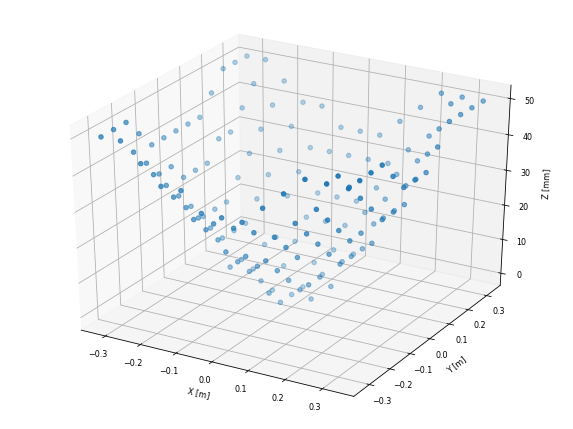

In [148]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data["x"], data["y"], data["z"])

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [mm]')
plt.rcParams.update({'font.size': 8})
fig.tight_layout()

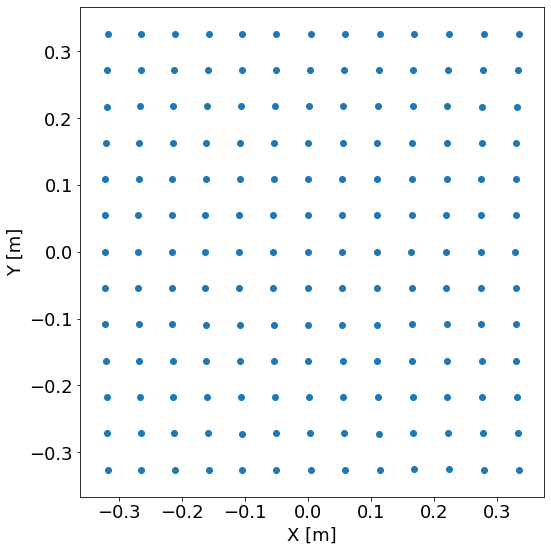

In [104]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.scatter(data["x"], data["y"])

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
plt.rcParams.update({'font.size': 18})
fig.tight_layout()
plt.savefig("GrigliaPunti", dpi=400)

This shows a contour plot of the previous 3D plot

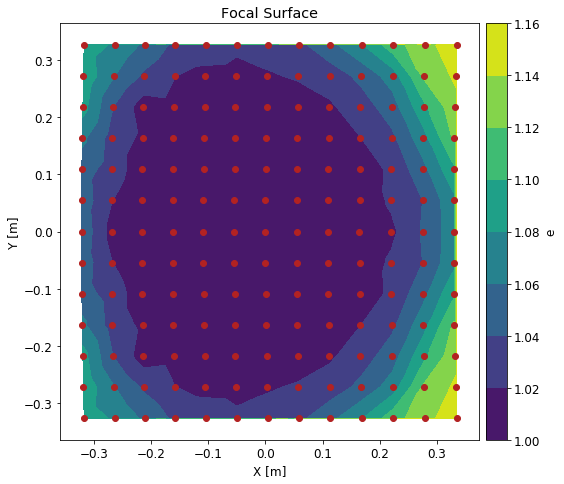

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = ax.tricontourf(data["x"], data["y"], data["e"])
ax.set_aspect("equal")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_title("Focal Surface")
ax.scatter(data["x"], data["y"], color="firebrick")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

cbar = fig.colorbar(g, cax=cax)
cbar.set_label("e")
fig.tight_layout()
plt.rcParams.update({'font.size': 12})
plt.savefig("ContourPlot_e.pdf", dpi=400)

Let's investigate the dependency of ellipticity on the position on the focal plane. We use `scipy.interpolate` to build two objects:

- a `e_func` object, which behaves like a function and associates a pair `(x, y)` to an (interpolated) ellipticity;
- a `e_grid` matrix, which contains a linear interpolation of the ellipticity for all the pairs `(x, y)` we have read above from the data file.

In [6]:
def linspace(vec, n):
    return np.linspace(np.min(vec), np.max(vec), n)

xpoints = linspace(data["x"], 100)
ypoints = linspace(data["y"], 100)

e_func = interp2d(data["x"], data["y"], data["e"], kind="linear")

e_grid = griddata((data["x"], data["y"]), data["e"], (xpoints[None, :], ypoints[:, None]), method="linear")

You can see that `e_func` behaves like a function

In [7]:
e_func(-0.316965, 0.326756)

array([1.091361])

In [12]:
e_grid.size

10000

Let's plot the ellipticity on the X-Y plane, marking the data points with red dots:

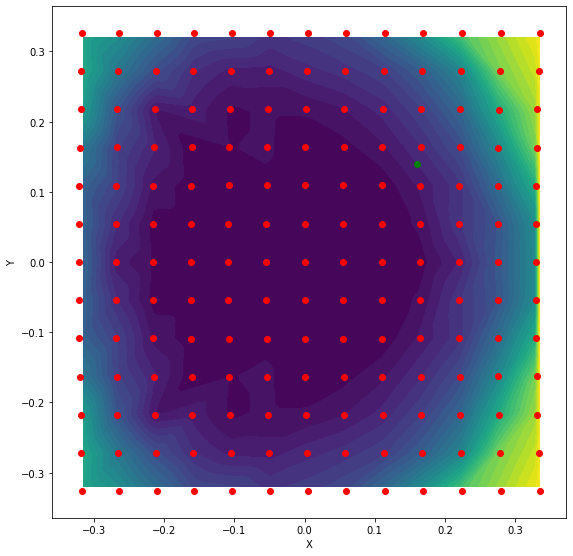

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.contourf(xpoints, ypoints, e_grid, 30)
axes.scatter(data["x"], data["y"], color="red")
axes.scatter([0.16], [0.14], color="green")
axes.set_aspect("equal")
axes.set_xlabel("X")
axes.set_ylabel("Y")
fig.tight_layout()

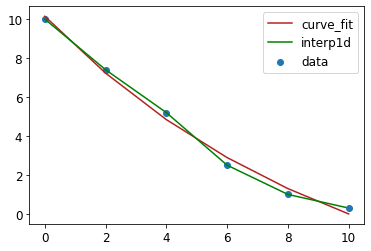

In [10]:
import numpy as np
import matplotlib.pylab as plt
from scipy import interpolate
from scipy import optimize

np.random.seed(0)
x_data = np.linspace(0, 10, num=6)
y_data = [10, 7.4, 5.2, 2.5, 1, 0.3]

#curve_fit
def test_func(x, a, b, c, d):
    return a**((b*x)+c)+d

popt, pcov = optimize.curve_fit(test_func, x_data, y_data)

#interp1d
f = interpolate.interp1d(x_data, y_data)
xnew = np.arange(0, 10, 0.1)
ynew = f(xnew)

#plot
plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data, label='data')
#plot curve_fit
plt.plot(x_data, test_func(x_data, *popt), label='curve_fit', color='firebrick')
#plot interp1d
plt.plot(xnew, ynew, label='interp1d', color='green')

plt.legend(loc='best')
plt.savefig("EsempioInterpolazione.pdf", dpi=400)

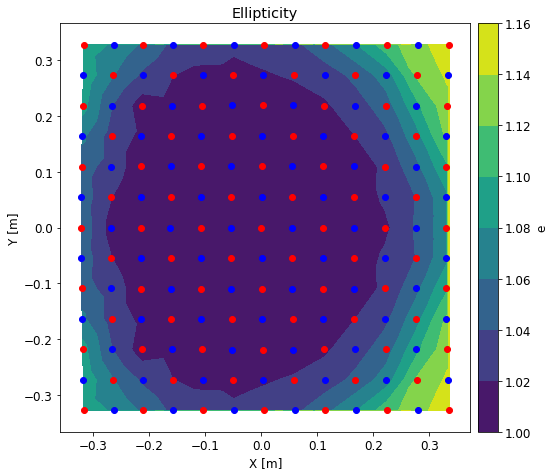

In [11]:
import functions as fc
data = pd.read_csv('data_fs.dat', delim_whitespace=True, decimal=",")
fc.add_bool(data)
data_int = data[data['check'] == True]
data_check = data[data['check'] == False]


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = ax.tricontourf(data["x"], data["y"], data["e"])
ax.set_aspect("equal")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_title("Ellipticity")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

pt_int = ax.scatter(data_int["x"], data_int["y"], color="red")
pt_check = ax.scatter(data_check["x"], data_check["y"], color="b")
#plt.legend((pt_int, pt_check), ('Interpolation', 'Check'), scatterpoints=1, fontsize=10)

cbar = fig.colorbar(g, cax=cax)
cbar.set_label("e")
fig.tight_layout()
plt.rcParams.update({'font.size': 16})
fig.tight_layout()

plt.savefig("ContourPlot_e.pdf", dpi=400)

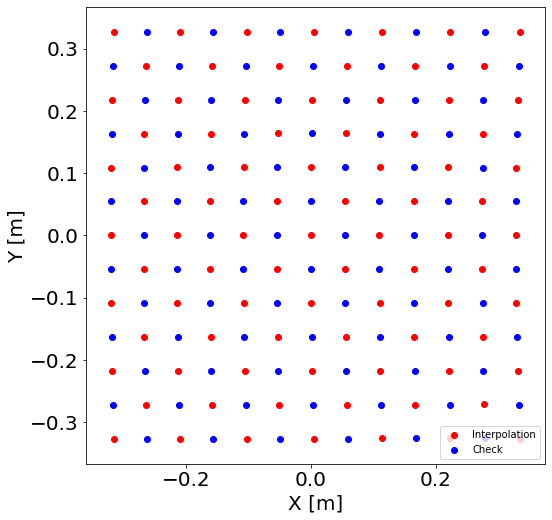

In [151]:
fig = plt.figure(figsize=(16, 8))


ax = fig.add_subplot(122)
pt_int = ax.scatter(data_int["x"], data_int["y"], color="red")
pt_check = ax.scatter(data_check["x"], data_check["y"], color="b")
ax.set_aspect("equal")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
plt.legend((pt_int, pt_check), ('Interpolation', 'Check'), loc=4 ,scatterpoints=1, fontsize=10)
fig.tight_layout()
plt.rcParams.update({'font.size': 20})

In [169]:
data_prob = data[data["y"]>0.3]

In [170]:
data_prob = data_prob[data["check"]==False]
data_prob

/Users/eleonoragatti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,id,x,y,z,fwhm_x,fwhm_y,e,tilt,co_max,cx_max,xpd,sub_spill,main_spill,check
13,294,-0.263845,0.326474,50,0.391116,0.363218,1.076807,-42.778528,53.95,"13,31",40.64,0.001201,0.004901,False
39,838,-0.157307,0.326597,40,0.369303,0.356781,1.035098,-20.322200,54.29,"11,71",42.58,0.000700,0.005969,False
65,1383,-0.049570,0.326640,35,0.361194,0.352552,1.024513,9.861373,54.46,"10,39",44.08,0.000528,0.006205,False
91,1929,0.059248,0.326600,35,0.363217,0.350828,1.035313,30.863368,54.45,"10,59",43.86,0.000526,0.006561,False
117,2477,0.168829,0.326094,45,0.379879,0.352218,1.078534,-135.039205,54.22,"11,48",42.74,0.000648,0.007589,False
143,3024,0.279492,0.326170,50,0.350854,0.397679,1.133462,-34.367081,54.02,"13,48",40.54,0.000950,0.009472,False


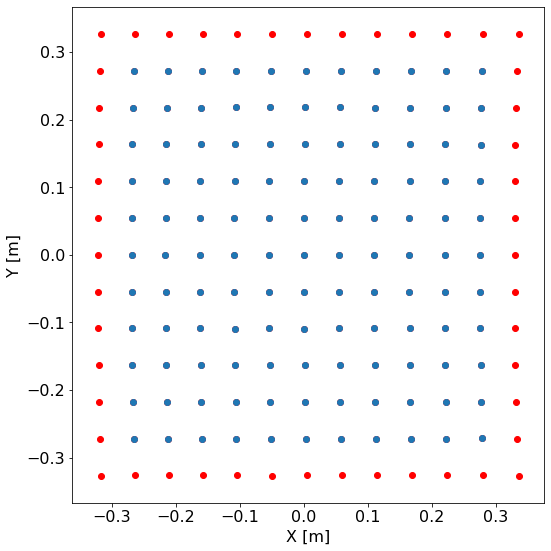

In [12]:
mask = (abs(data["x"]) < 0.3) & (abs(data["y"]) < 0.3)
data_mask = data[mask]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.scatter(data["x"], data["y"], color="r")
ax.scatter(data_mask["x"], data_mask["y"], color="tab:blue")
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
plt.rcParams.update({'font.size': 18})
fig.tight_layout()
plt.savefig("PuntiMask.pdf", dpi=600)